<a href="https://colab.research.google.com/github/JDM-1609/Statistical-Process-Control-in-Injection-Machines/blob/main/SPC_Analysis_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXTRACCIÓN DE ESTADÍSTICOS INICIALES

**SEPARACIÓN MANUAL DE LAS SECCIONES DEL CSV**

El siguiente código separa en DataFrames diferentes cada una de las secciones del CSV (Info. Contextual, estadísticos y datos crudos) de manera manual, dado que se le debe especificar los indices en donde comienza y termina cada sección. Este código tiene como limitante que si la distribución de los datos del CSV cambia el codigo se rompe (se tendrían que especificar los nuevos indices de inicio y fin de cada sección)

In [5]:
import csv
from pathlib import Path
from io import StringIO
import pandas as pd
import numpy as np

# OPCIONAL: para visualización de los datos en el DF

pd.set_option("display.max_columns", 20) # Controla cuántas columnas se muestran sin omisiones
pd.set_option("display.float_format", lambda v: f"{v:.4g}") # Muestra valores con hasta 4 cifras significativas

# Encoding de los archivos del ALS
ENCODING_ALS = "UTF-8"


In [6]:
# Carga de datos
from google.colab import files

uploaded = files.upload()
RUTA_IN = next(iter(uploaded.keys()))
print("Archivo cargado:", RUTA_IN)


Saving DATA PRUEBA.csv to DATA PRUEBA (1).csv
Archivo cargado: DATA PRUEBA (1).csv


In [7]:
# Indices start & end de cada sección
# SECCIONES
idx_info = 0           # Información contextual
idx_stats_start = 2    # Start Estadísticos
idx_stats_end = 21     # End Estadísticos
idx_raw_start = 23     # Datos crudos

In [8]:
# FUNCIONES EMPLEADAS

# Lee el CSV como strings y devuelve una lista donde cada elemento es una línea del CSV
def leer_lineas(ruta_csv: str, encoding: str = ENCODING_ALS):
    raw = Path(ruta_csv).read_text(encoding=encoding, errors="replace")
    lines = raw.splitlines()  # Este método siempre devuelve una lista
    return lines

# Devuelve la sección "Información Contextual" como un DF
def parse_info_contextual(lines, idx_info: int = 0) -> pd.DataFrame:
    line = lines[idx_info]  # Se toma únicamente la primera línea
    cells = next(csv.reader([line], delimiter=",", quotechar='"'))

    # Limpieza eliminando vacíos y el elemento "Valores reales"
    cleaned = []
    for c in cells:
        c = c.strip().strip('"')
        if not c:  # Vacío -> se omite
            continue
        if c.lower() == "valores reales":
            continue
        cleaned.append(c)

    claves  = cleaned[0::2]
    valores = cleaned[1::2]

    df_info = pd.DataFrame([valores], columns=claves)
    return df_info

# Devuelve la sección "Estadísticos" como un DF
def parse_estadisticos(lines, idx_start: int, idx_end: int) -> pd.DataFrame:

    # Se unen las líneas de la sección en un solo string tipo CSV
    block = "\n".join(lines[idx_start:idx_end])

    # Leemos este bloque como si fuera un CSV independiente
    df_stats = pd.read_csv(
        StringIO(block),
        sep=",",
        decimal=",",
        thousands=".",
        quotechar='"',
        encoding=ENCODING_ALS,
        engine="python",
        )
    # Los índices del df son los nombres de los estadísticos
    df_stats.index.name = "Estadísticos"

    # Ajuste de los encabezados de las columnas
    cols = list(df_stats.columns)
    if str(cols[0]).strip() == "":
      df_stats.columns = cols[1:] + cols[:1] # Se desplazan las columnas a la izq
      df_stats = df_stats.dropna(axis=1, how="all") # Elimina la columna vacía

    return df_stats

# Devuelve la sección "Datos Crudos" como un DF
def parse_datos_crudos(lines, idx_start: int) -> pd.DataFrame:

    # Se unen las líneas desde idx_start hasta final de los datos
    block = "\n".join(lines[idx_start:])

    df_raw = pd.read_csv(
        StringIO(block),
        sep=",",
        decimal=",",
        thousands=".",
        quotechar='"',
        encoding=ENCODING_ALS,
        engine="python",
    )
    df_raw.columns = [str(c).strip() for c in df_raw.columns]
    df_raw = df_raw.reset_index()

    cols = list(df_raw.columns)
    df_raw.columns = cols[1:] + cols[:1] # Se desplazan las columnas a la izq



    # 4. Eliminar columnas completamente vacías (NaN en todas las filas)
    df_raw = df_raw.dropna(axis=1, how="all")



    return df_raw


In [9]:
# EJECUCIÓN

# Leer todas las líneas del archivo
lines = leer_lineas(RUTA_IN, encoding=ENCODING_ALS)
print(f"NÚMERO TOTAL DE LÍNEAS EN EL ARCHIVO: {len(lines)}\n")

# Información contextual
df_info = parse_info_contextual(lines, idx_info=idx_info)
print("INFORMACIÓN CONTEXTUAL:")
display(df_info)

# Estadísticos
df_stats = parse_estadisticos(lines, idx_start=idx_stats_start, idx_end=idx_stats_end)
print("\nTABLA ESTADÍSTICOS PRINCIPALES (Vista rápida):")
display(df_stats.head())

# Datos crudos
df_raw = parse_datos_crudos(lines, idx_start=idx_raw_start)
print("\nDATOS CRUDOS MEDIDOS POR EL ALS (Vista rápida):")
display(df_raw.head())


NÚMERO TOTAL DE LÍNEAS EN EL ARCHIVO: 124

INFORMACIÓN CONTEXTUAL:


,M�quina,Pedido,Programa
0,INY14,194209,12667-1



TABLA ESTADÍSTICOS PRINCIPALES (Vista rápida):


,t4012 [s],t4018 [s],t4015 [s],V4062 [cm�],p4072 [bar],V4065 [cm�]
Estadísticos,,,,,,
Valor nominal,16.64,0.69,1.85,7.56,1493,9.98
Tolerancia inferior,15.64,0.59,-0.15,6.06,1343,9.48
Tolerancia superior,17.64,0.79,3.85,9.06,1643,10.48
M�nimo,16.89,0.69,1.87,7.45,1536,9.98
M�ximo,17.6,0.7,1.94,7.86,1594,10



DATOS CRUDOS MEDIDOS POR EL ALS (Vista rápida):


,Muestra aleatoria,Momento,Cantidad piezas,t4012 [s],t4018 [s],t4015 [s],V4062 [cm�],p4072 [bar],V4065 [cm�]
0,65/1,8 oct 2025 5:31:05,4968,17.37,0.69,1.89,7.67,1563,10
1,65/2,8 oct 2025 5:31:22,4976,17.44,0.69,1.88,7.7,1580,9.99
2,65/3,8 oct 2025 5:31:40,4984,17.49,0.69,1.88,7.72,1581,9.98
3,65/4,8 oct 2025 5:31:57,4992,17.38,0.69,1.89,7.67,1566,9.99
4,65/5,8 oct 2025 5:32:15,5000,17.51,0.69,1.88,7.75,1580,10


In [31]:
# FUNCIONES PARA EXTRACCIÓN DE DATOS NECESARIOS PARA SEGUIMIENTOS

# Limitar a 3 cifras significativas
def sig(x, n=3):
    try:
        return float(f"{x:.{n}g}")
    except:
        return x

# Construcción de la tabla final para seguimientos
def construir_resumen(df_stats):

    variables = df_stats.columns.tolist()
    filas = []

    for var in variables:
        try:
            # Extraer valores de df_stats
            valor_nominal = df_stats.loc["Valor nominal", var]
            xqq           = df_stats.loc["xqq", var]
            sigma         = df_stats.loc["Sigma", var]
            cp            = df_stats.loc["Cp", var]
            cpd           = df_stats.loc["Cpd", var]

            # Calcular Rango
            rango = df_stats.loc["Tolerancia superior", var] - valor_nominal

            # Calcular Desviación
            desviacion = (cp - cpd) / (cp) if cp != 0 else np.nan

            # Convertir a 3 cifras significativas
            fila = [
                var,
                sig(rango),
                sig(valor_nominal),
                sig(xqq),
                sig(sigma),
                sig(cp),
                sig(cpd),
                sig(desviacion)
            ]

        except KeyError:
            fila = [var] + [np.nan]*7

        filas.append(fila)

    df_resumen = pd.DataFrame(
        filas,
        columns=[
            "Variables", "Rango", "Valor nominal", "Media",
            "Sigma_W", "Cp", "Cpk", "Desviación"
        ]
    )

    return df_resumen

In [34]:
df_resumen = construir_resumen(df_stats)
df_resumen

,Variables,Rango,Valor nominal,Media,Sigma_W,Cp,Cpk,Desviación
0,t4012 [s],1,16.6,17.4,0.065,5.12,1.14,0.778
1,t4018 [s],0.1,0.69,0.694,0.003,11.1,10.7,0.0355
2,t4015 [s],2,1.85,1.88,0.006,113,111,0.0173
3,V4062 [cm�],1.5,7.56,7.7,0.065,7.74,7.12,0.0812
4,p4072 [bar],150,1490,1570,9.5,5.3,2.6,0.509
5,V4065 [cm�],0.5,9.98,9.99,0.007,23.2,22.6,0.0252


In [29]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def exportar_resumen_a_pdf(df_resumen, nombre_pdf="resumen_estadisticos.pdf"):
    """
    Crea un PDF con una tabla que contiene el DataFrame df_resumen.
    Guarda el archivo en el directorio actual de Colab.
    """

    # Tamaño de la figura en función de filas y columnas
    n_filas, n_cols = df_resumen.shape
    ancho = max(8, n_cols * 1.3)      # ajusta si quieres más ancho
    alto = max(2, n_filas * 0.6 + 1)  # ajusta si quieres más alto

    fig, ax = plt.subplots(figsize=(ancho, alto))
    ax.axis("off")  # ocultar ejes

    tabla = ax.table(
        cellText=df_resumen.values,
        colLabels=df_resumen.columns,
        loc="center",
        cellLoc="center",
    )

    # Ajustes estéticos
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(8)
    tabla.scale(1.1, 1.3)  # escala (ancho, alto) de las celdas

    plt.tight_layout()

    # Guardar en PDF
    with PdfPages(nombre_pdf) as pdf:
        pdf.savefig(fig, bbox_inches="tight")

    plt.close(fig)
    print(f"PDF generado: {nombre_pdf}")


In [30]:
exportar_resumen_a_pdf(df_resumen, "Resumen_Estadisticos_ALS.pdf")


PDF generado: Resumen_Estadisticos_ALS.pdf


###TAREAS
1. Se tiene ya los datos necesarios en df_resumen para completar la plantilla de seguimientos por máquina. En este punto, evaluar opción de incluir las columnas Cpk estimado y Rango ajustado, de forma tal que con un input se pueda ingresar el valor del rango ajustado al que se quiere llegar y calcule el Cpk estimado. Adicionalmente, evaluar la opción de generar un archivo PDF donde se muestre esta tabla final (Tal cual a la de la plantilla de seguimientos) y en la cabezara se muestra la informacion contextual (Pedido, Molde, Descripcion, Material, fecha de analisis, fecha datos analizados) y ademas, crea un input donde se pueda escribir comentarios y se muestren en la parte inferior del PDF

2. Se debe realizar el código que permita graficar las cartas de control que nos interesan a partir de los datos crudos. Como son muchos datos, se puede evaluar la opción de que la grafica tenga una barra deslizante para el desplazamiento por todo el gráfico, de manera que todos los datos se muestren de manera correcta

In [48]:
import pandas as pd
import numpy as np

def procesar_datos_spc(df_raw):
    """
    Procesa df_raw para cálculos SPC y devuelve:
    - df_raw limpio con columnas subgrupo y pos
    - df_xbar: promedios por subgrupo
    - df_s: desviaciones estándar por subgrupo
    - xbar_prom_global: promedio de los X̄
    - s_prom_global: promedio de los S
    """

    df = df_raw.copy()

    # ================================
    # 1. Separar 'Muestra aleatoria'
    # ================================
    df[["subgrupo", "pos"]] = df["Muestra aleatoria"].str.split("/", expand=True)
    df["subgrupo"] = df["subgrupo"].astype(int)
    df["pos"] = df["pos"].astype(int)

    # ================================
    # 2. Identificar variables numéricas
    # ================================
    columnas_no_variables = ["Muestra aleatoria", "Momento", "Cantidad piezas", "subgrupo", "pos"]
    variables = [c for c in df.columns if c not in columnas_no_variables]

    # ================================
    # 3. Calcular X̄ y S por subgrupo
    # ================================
    df_xbar = df.groupby("subgrupo")[variables].mean()
    df_s = df.groupby("subgrupo")[variables].std(ddof=1)

    # ================================
    # 4. Promedios globales
    # ================================
    xbar_prom_global = df_xbar.mean()
    s_prom_global = df_s.mean()

    return df, df_xbar, df_s, xbar_prom_global, s_prom_global


In [49]:
df_limpio, df_xbar, df_s, xbar_prom, s_prom = procesar_datos_spc(df_raw)


In [56]:
df_xbar

,t4012 [s],t4018 [s],t4015 [s],V4062 [cm�],p4072 [bar],V4065 [cm�]
subgrupo,,,,,,
65,17.44,0.69,1.884,7.702,1574,9.992
66,17.44,0.69,1.88,7.71,1575,9.994
67,17.4,0.696,1.888,7.66,1565,9.996
68,17.4,0.7,1.886,7.682,1573,9.998
69,17.44,0.696,1.886,7.674,1567,9.992
70,17.43,0.698,1.886,7.69,1573,9.994
71,17.41,0.692,1.884,7.696,1575,9.996
72,17.44,0.698,1.886,7.65,1570,9.988
73,17.46,0.696,1.884,7.644,1562,9.992


In [57]:
import matplotlib.pyplot as plt

def graficar_carta_x(df_xbar, xbar_prom, df_stats, variable, titulo=None):
    """
    Grafica la carta X (X̄) para una variable específica.

    - df_xbar: DataFrame con promedios por subgrupo (índice = subgrupo, columnas = variables)
    - xbar_prom: Serie con el promedio global de X̄ por variable
    - df_stats: DataFrame de estadísticos (índice incluye LISx y LIIx)
    - variable: nombre de la columna que se quiere graficar (ej: 't4012 [s]')
    """

    # Serie de promedios por subgrupo para la variable
    xbar_subgrupos = df_xbar[variable]
    subgrupos = xbar_subgrupos.index.astype(int)   # asegurar que sean enteros

    # Línea central: promedio global de los X̄ para esa variable
    xbar_global = xbar_prom[variable]

    # Límites de especificación desde df_stats
    lisx = df_stats.loc["LISx", variable]   # Límite superior de especificación
    liix = df_stats.loc["LIIx", variable]   # Límite inferior de especificación

    # Figura
    fig, ax = plt.subplots(figsize=(10, 5))

    # Puntos X̄ por subgrupo
    ax.plot(subgrupos, xbar_subgrupos, marker="o", linestyle="-", label="X̄ por subgrupo")

    # Línea central (promedio global)
    ax.axhline(y=xbar_global, linestyle="--", linewidth=1.5, label="Media X̄ global")

    # Límites de especificación (líneas continuas)
    ax.axhline(y=lisx, linestyle="-", linewidth=1.2, label="LISx")
    ax.axhline(y=liix, linestyle="-", linewidth=1.2, label="LIIx")

    # Etiquetas y título
    ax.set_xlabel("Subgrupos")
    ax.set_ylabel(variable)
    if titulo is None:
        titulo = f"Carta X̄ - {variable}"
    ax.set_title(titulo)

    # 👉 Forzar ticks SOLO en los subgrupos existentes (enteros)
    ax.set_xticks(subgrupos)

    # Opcional: si son muchos subgrupos, se pueden rotar las etiquetas
    # ax.tick_params(axis="x", rotation=45)

    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)
    fig.tight_layout()
    plt.show()


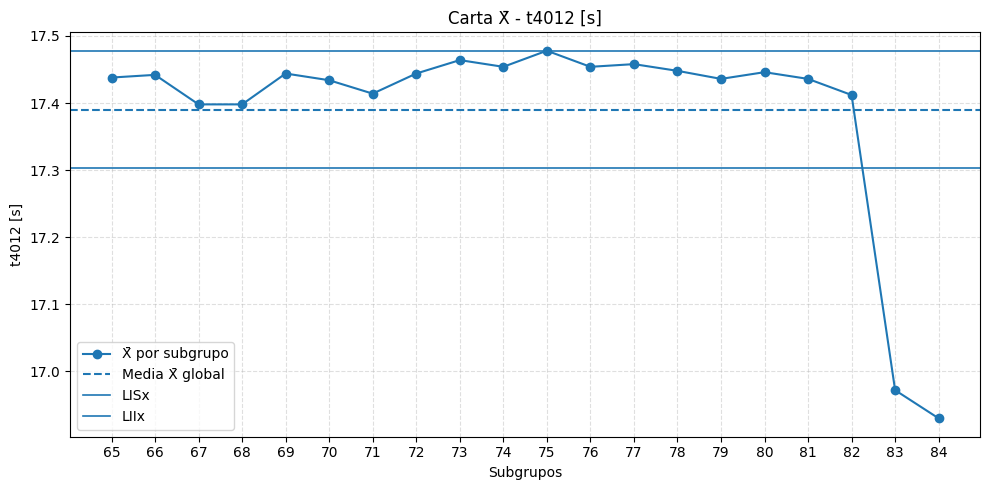

In [58]:
graficar_carta_x(df_xbar, xbar_prom, df_stats, "t4012 [s]")


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact

def graficar_carta_x_interactiva(df_xbar, xbar_prom, df_stats, variable, window=50, titulo=None):
    """
    Carta X̄ interactiva para una variable.

    - df_xbar: X̄ por subgrupo (índice = subgrupo, columnas = variables)
    - xbar_prom: Serie con media global de X̄ por variable
    - df_stats: DF de estadísticos (índice incluye 'LISx' y 'LIIx')
    - variable: nombre de la columna a graficar (ej: 't4012 [s]')
    - window: cantidad de subgrupos visibles por ventana (ej. 50)
    """

    # Datos base
    xbar_subgrupos = df_xbar[variable]
    subgrupos = xbar_subgrupos.index.astype(int).to_numpy()

    xbar_global = float(xbar_prom[variable])
    lisx = float(df_stats.loc["LISx", variable])
    liix = float(df_stats.loc["LIIx", variable])

    # Escala Y automática (con un pequeño margen)
    all_vals = np.concatenate([xbar_subgrupos.values, [lisx, liix, xbar_global]])
    y_min = all_vals.min()
    y_max = all_vals.max()
    margen = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
    y_min -= margen
    y_max += margen

    # Para muchos subgrupos, mostraremos "ventanas" deslizables
    n = len(subgrupos)
    if window > n:
        window = n

    if titulo is None:
        titulo = f"Carta X̄ - {variable}"

    def plot_window(start_idx: int):
        end_idx = min(start_idx + window, n)
        sg = subgrupos[start_idx:end_idx]
        vals = xbar_subgrupos.iloc[start_idx:end_idx]

        plt.figure(figsize=(10, 5))
        ax = plt.gca()

        # Serie X̄
        ax.plot(sg, vals, marker="o", linestyle="-", label="X̄ por subgrupo")

        # Media global
        ax.axhline(y=xbar_global, linestyle="--", linewidth=1.5, label="Media X̄ global")

        # Límites de especificación
        ax.axhline(y=lisx, linestyle="-", linewidth=1.2, label="LISx")
        ax.axhline(y=liix, linestyle="-", linewidth=1.2, label="LIIx")

        # Ejes, título, etc.
        ax.set_xlabel("Subgrupos")
        ax.set_ylabel(variable)
        ax.set_title(titulo)

        # Eje X: solo los subgrupos visibles, enteros
        ax.set_xlim(sg.min() - 0.5, sg.max() + 0.5)
        ax.set_xticks(sg)

        # Eje Y centrado en el rango de datos + márgenes
        ax.set_ylim(y_min, y_max)

        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Slider para moverse por los subgrupos
    max_start = max(n - window, 0)
    slider = IntSlider(
        value=0,
        min=0,
        max=max_start,
        step=1,
        description="Inicio:",
        continuous_update=False,
    )

    interact(plot_window, start_idx=slider)


In [60]:
graficar_carta_x_interactiva(df_xbar, xbar_prom, df_stats, "t4012 [s]", window=50)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Inicio:', max=0), Output()), _d…